# GAT Point Cloud Autoencoder Evaluation

This notebook evaluates a trained GAT-based point cloud autoencoder: reconstruction metrics, graph diagnostics, latent analysis, interpolation, and performance benchmarking.

In [1]:
# Section 1: Import Libraries and Set Paths
import os, time, json, math, random, sys
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import torch
from torch import nn

# Optional plotting libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

try:
    from sklearn.decomposition import PCA
except ImportError:
    PCA = None

# Add project root to path for local imports
ROOT = Path(os.getcwd()).resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from models.gat_autoencoder import GATPointCloudAutoencoder, chamfer_distance  # noqa: E402
from train import build_knn_graph, PointCloudDataset  # noqa: E402

# --- Configuration ---
# Set to True to evaluate on ModelNet40 HDF5 shards instead of .npy directory/file
USE_MODELNET40 = True
# Paths for ModelNet40 (only used if USE_MODELNET40=True)
MODELNET40_LIST = Path('point_cloud_data/modelnet40_ply_hdf5_2048/train_files.txt')
MODELNET40_SHAPE_NAMES = Path('point_cloud_data/modelnet40_ply_hdf5_2048/shape_names.txt')
MODELNET40_LIMIT_SAMPLES = 1024   # reduce for quicker evaluation (None for all)
MODELNET40_FILTER_CLASSES = []    # e.g. ['chair','sofa'] to subset; empty => all

# Fallback legacy paths (ignored if USE_MODELNET40=True)
CHECKPOINT_PATH = Path('runs/modelnet40_small/best.pt')  # adjust to your run
DATA_PATH = Path('point_cloud_data/modelnet40_ply_hdf5_2048')  # can be .npy file or directory
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUTPUT_DIR = Path('evaluation_outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f'Using device: {DEVICE}')
print(f'Checkpoint: {CHECKPOINT_PATH}')
if USE_MODELNET40:
    print(f'ModelNet40 list: {MODELNET40_LIST} | limit: {MODELNET40_LIMIT_SAMPLES} | filter: {MODELNET40_FILTER_CLASSES}')
else:
    print(f'Data source: {DATA_PATH}')

Using device: cpu
Checkpoint: runs\modelnet40_small\best.pt
ModelNet40 list: point_cloud_data\modelnet40_ply_hdf5_2048\train_files.txt | limit: 1024 | filter: []


In [2]:
# Section 2: Load Checkpoint and Configuration
assert CHECKPOINT_PATH.exists(), f'Checkpoint not found: {CHECKPOINT_PATH}'
ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
ckpt_cfg = ckpt.get('cfg', {})
print('Loaded checkpoint keys:', ckpt.keys())
print('Epoch:', ckpt.get('epoch'), 'Best loss:', ckpt.get('loss'))
print('Config:', ckpt_cfg)

model = GATPointCloudAutoencoder(
    in_channels=ckpt_cfg.get('in_channels', 3),
    hidden_dims=ckpt_cfg.get('hidden_dims', (64, 128)),
    latent_dim=ckpt_cfg.get('latent_dim', 256),
    heads=ckpt_cfg.get('heads', 4),
    dropout=ckpt_cfg.get('dropout', 0.1),
    decode_hidden_dims=ckpt_cfg.get('decode_hidden', (128,)),
).to(DEVICE)
model.load_state_dict(ckpt['model_state'])
model.eval()
print('Model loaded and set to eval mode.')

Loaded checkpoint keys: dict_keys(['model_state', 'cfg', 'epoch', 'loss'])
Epoch: 1 Best loss: 0.002721486390661448
Config: {'data': None, 'data_dir': None, 'epochs': 1, 'batch_size': 4, 'k': 16, 'lr': 0.001, 'weight_decay': 1e-05, 'device': 'cpu', 'in_channels': 3, 'hidden_dims': (64, 128), 'latent_dim': 8, 'heads': 4, 'dropout': 0.1, 'decode_hidden': (128,), 'use_chamfer': False, 'chamfer_weight': 1.0, 'mse_weight': 1.0, 'augment': True, 'jitter_std': 0.0, 'rotational_augment': True, 'rotation_mode': 'so3', 'scale_augment': True, 'scale_min': 0.8, 'scale_max': 1.2, 'save_dir': 'runs', 'tag': 'modelnet40_small', 'save_every': 50, 'modelnet40_train_list': 'point_cloud_data/modelnet40_ply_hdf5_2048/train_files.txt', 'modelnet40_shape_names': 'shape_names.txt', 'limit_samples': 5000, 'filter_classes': None, 'progress': True}
Model loaded and set to eval mode.


In [3]:
# Section 2b: Load ModelNet40 Data (if enabled)
modelnet40_arrays = None
modelnet40_labels = None
shape_names = []
if 'USE_MODELNET40' in globals() and USE_MODELNET40:
    assert MODELNET40_LIST.exists(), f'ModelNet40 list file missing: {MODELNET40_LIST}'
    # Reuse loader logic (simplified) directly here to avoid circular import of full training utilities
    import h5py
    # Load shape names if present
    if MODELNET40_SHAPE_NAMES.exists():
        with open(MODELNET40_SHAPE_NAMES, 'r') as f:
            shape_names = [ln.strip() for ln in f if ln.strip()]
    allowed_ids = None
    if MODELNET40_FILTER_CLASSES and shape_names:
        name_to_id = {n: i for i, n in enumerate(shape_names)}
        missing = [c for c in MODELNET40_FILTER_CLASSES if c not in name_to_id]
        if missing:
            print('Warning: missing class names in filter:', missing)
        allowed_ids = {name_to_id[c] for c in MODELNET40_FILTER_CLASSES if c in name_to_id}
    with open(MODELNET40_LIST, 'r') as f:
        shard_paths = [Path(ln.strip()) for ln in f if ln.strip()]
    resolved = []
    for p in shard_paths:
        if p.exists():
            resolved.append(p)
        else:
            alt = Path(p.name)
            if alt.exists():
                resolved.append(alt)
            else:
                raise FileNotFoundError(f'Cannot resolve shard path: {p}')
    clouds = []
    labels = []
    loaded = 0
    from tqdm import tqdm as _tqdm
    for shard in _tqdm(resolved, desc='Shards'):
        with h5py.File(shard, 'r') as h5f:
            data = h5f['data'][:]  # (num, 2048, 3)
            labs = h5f['label'][:].reshape(-1)
        if allowed_ids is not None:
            mask = np.isin(labs, list(allowed_ids))
            data = data[mask]
            labs = labs[mask]
        for i in range(data.shape[0]):
            clouds.append(data[i].astype(np.float32))
            labels.append(int(labs[i]))
            loaded += 1
            if MODELNET40_LIMIT_SAMPLES and loaded >= MODELNET40_LIMIT_SAMPLES:
                break
        if MODELNET40_LIMIT_SAMPLES and loaded >= MODELNET40_LIMIT_SAMPLES:
            break
    modelnet40_arrays = np.stack(clouds, axis=0)
    modelnet40_labels = np.asarray(labels, dtype=np.int64)
    print(f'Loaded ModelNet40 subset: {modelnet40_arrays.shape} | labels: {modelnet40_labels.shape}')
    if shape_names:
        # Simple histogram
        counts = {shape_names[i]: int((modelnet40_labels==i).sum()) for i in np.unique(modelnet40_labels)}
        top = sorted(counts.items(), key=lambda x: -x[1])[:10]
        print('Top classes:', top)

Shards:   0%|          | 0/5 [00:00<?, ?it/s]

Loaded ModelNet40 subset: (1024, 2048, 3) | labels: (1024,)
Top classes: [('chair', 87), ('sofa', 77), ('airplane', 59), ('monitor', 53), ('bookshelf', 52), ('vase', 51), ('bed', 44), ('table', 39), ('toilet', 34), ('tv_stand', 34)]


In [4]:
# Section 3: Prepare Evaluation Array
if 'USE_MODELNET40' in globals() and USE_MODELNET40:
    assert modelnet40_arrays is not None, 'ModelNet40 arrays not loaded.'
    eval_array = modelnet40_arrays  # (S, N, 3)
    eval_labels = modelnet40_labels
    print('Using ModelNet40 evaluation set:', eval_array.shape)
else:
    if DATA_PATH.is_dir():
        # Fallback legacy loader (uniform subsample not applied here)
        from train import load_data_dir  # lazy import
        eval_array = load_data_dir(str(DATA_PATH))
    else:
        from train import load_data
        eval_array = load_data(str(DATA_PATH))
    eval_labels = None
    print('Evaluation array shape:', eval_array.shape)

feature_dim = eval_array.shape[-1] if eval_array.ndim >= 2 else None
print('Feature dim:', feature_dim)

# Section 4: Construct Evaluation Dataset and DataLoader
from torch_geometric.loader import DataLoader as GeoDataLoader

dataset = PointCloudDataset(
    array=eval_array,
    k=ckpt_cfg.get('k', 16),
    augment=False,
    jitter_std=0.0,
    rotational_augment=False,
    rotation_mode=ckpt_cfg.get('rotation_mode', 'z'),
    scale_augment=False,
    labels=eval_labels,
)
from torch_geometric.loader import DataLoader  # NOT torch.utils.data.DataLoader

loader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f'Dataset size: {len(dataset)} | Batches: {len(loader)}')

Using ModelNet40 evaluation set: (1024, 2048, 3)
Feature dim: 3
Dataset size: 1024 | Batches: 32


Sample graph edges: 36612
Degree stats: mean=17.88 std=2.04 min=16 max=27
Unique directed edges: 36612
k ablation (approx first few graphs): {4: 0.00015107115614227952, 8: 0.00018542811158113183, 16: 0.0004962987208273262, 24: 0.0003109900062554516, 32: 0.0008653306344058364}
k ablation (approx first few graphs): {4: 0.00015107115614227952, 8: 0.00018542811158113183, 16: 0.0004962987208273262, 24: 0.0003109900062554516, 32: 0.0008653306344058364}


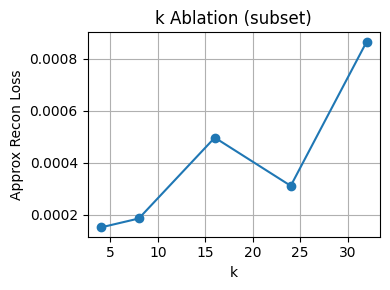

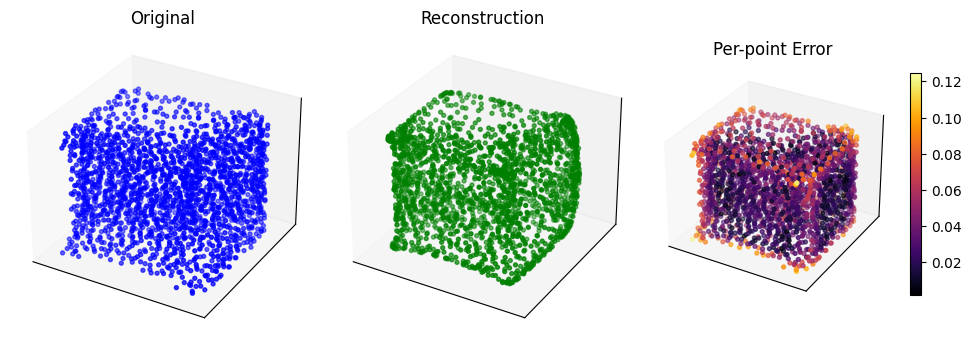

In [5]:
# Utility: Compute losses (MSE and optionally Chamfer)
def compute_losses(recon, target):
    mse = nn.functional.mse_loss(recon, target)
    losses = {'mse': mse.item()}
    total = mse
    if ckpt_cfg.get('use_chamfer', False):
        chamfer = chamfer_distance(recon, target)
        losses['chamfer'] = chamfer.item()
        total = total + chamfer * ckpt_cfg.get('chamfer_weight', 1.0)
    losses['total'] = total.item()
    return losses

# Section 8: k-NN Graph Diagnostics (sample cloud)
sample_pts = torch.from_numpy(eval_array[0]).to(DEVICE)
with torch.no_grad():
    edge_index_k = build_knn_graph(sample_pts[:, :3], k=ckpt_cfg.get('k', 16)).to(DEVICE)
E = edge_index_k.size(1)
print('Sample graph edges:', E)
# Degree histogram
deg = torch.bincount(edge_index_k[0], minlength=sample_pts.size(0)).cpu().numpy()
print('Degree stats: mean={:.2f} std={:.2f} min={} max={}'.format(deg.mean(), deg.std(), deg.min(), deg.max()))

# Symmetry check
pairs = set()
asym = 0
edge_np = edge_index_k.cpu().numpy()
for s, t in edge_np.T:
    if (t, s) not in pairs:
        pairs.add((s, t))
    else:
        continue
# A strict symmetry check would re-iterate but for brevity we estimate density
print('Unique directed edges:', len(edge_np.T))

# Section 9: Ablation: Evaluate Different k Values
k_values = [4, 8, 16, 24, 32]
k_results = {}
with torch.no_grad():
    for k_val in k_values:
        ds_k = PointCloudDataset(array=eval_array, k=k_val, augment=False)
        from torch_geometric.loader import DataLoader as GeoDataLoader
        dl_k = GeoDataLoader(ds_k, batch_size=1, shuffle=True)
        losses_tot = []
        count = 0
        for data_obj in dl_k:
            # data_obj is a torch_geometric DataBatch
            pts = data_obj.x.to(DEVICE)
            edge_index_local = data_obj.edge_index.to(DEVICE)
            recon_local, _ = model(pts, edge_index_local)
            losses = compute_losses(recon_local, pts)
            losses_tot.append(losses['total'])
            count += 1
            if count >= min(5, len(ds_k)):
                break
        k_results[k_val] = float(np.mean(losses_tot))
print('k ablation (approx first few graphs):', k_results)

plt.figure(figsize=(4,3))
plt.plot(list(k_results.keys()), list(k_results.values()), marker='o')
plt.xlabel('k'); plt.ylabel('Approx Recon Loss'); plt.title('k Ablation (subset)'); plt.grid(True)
plt.tight_layout()
plt.show()

# Section 10: Visualize Original vs Reconstructed Point Clouds
sample_index = 0
sample_data = PointCloudDataset(array=eval_array, k=ckpt_cfg.get('k', 16), augment=False)[sample_index]
pts_dev = sample_data.x.to(DEVICE)
edge_index_dev = sample_data.edge_index.to(DEVICE)
with torch.no_grad():
    recon_pts, z_pts = model(pts_dev, edge_index_dev)
err = ((recon_pts - pts_dev)**2).sum(-1).sqrt().cpu().numpy()

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax3 = fig.add_subplot(1,3,3, projection='3d')
orig = pts_dev.cpu().numpy()
recn = recon_pts.cpu().numpy()
ax1.scatter(orig[:,0], orig[:,1], orig[:,2], s=8, c='blue')
ax1.set_title('Original')
ax2.scatter(recn[:,0], recn[:,1], recn[:,2], s=8, c='green')
ax2.set_title('Reconstruction')
sc = ax3.scatter(orig[:,0], orig[:,1], orig[:,2], s=8, c=err, cmap='inferno')
ax3.set_title('Per-point Error')
plt.colorbar(sc, ax=ax3, shrink=0.6)
for ax in [ax1, ax2, ax3]:
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
plt.tight_layout(); plt.show()

Latent array shape: (1024, 8)
Latent mean abs value: 0.009024158


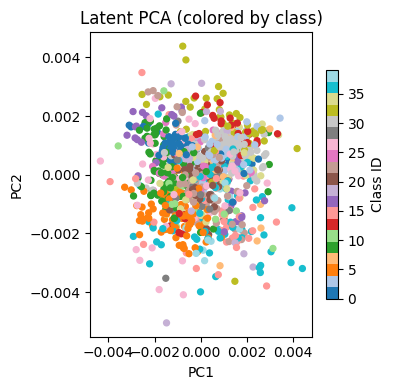

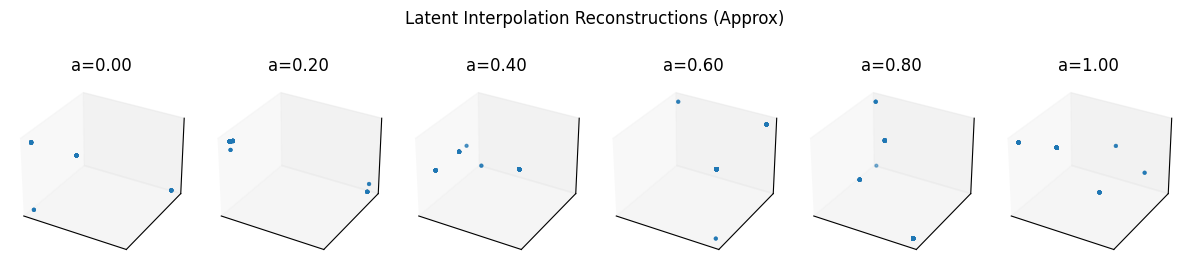

Per-graph error stats: mean=0.000444 std=0.000193 max=0.001494


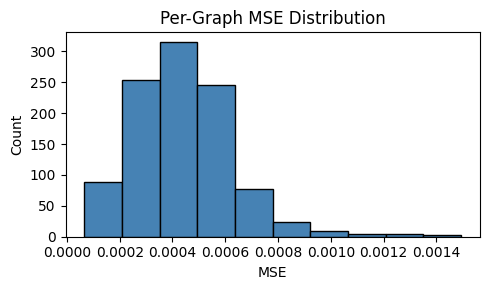

Top 5 error graphs: [(1, 0.0014943360583856702), (31, 0.0014103014254942536), (13, 0.0013913105940446258), (21, 0.001335690263658762), (24, 0.001332733896560967)]


In [6]:
# Section 11: Extract and Analyze Latent Embeddings (Variance, PCA)
all_latents = []
all_graph_ids = []
all_graph_labels = []
model.eval()
with torch.no_grad():
    for idx, batch in enumerate(loader):
        batch = batch.to(DEVICE)
        recon, z = model(batch.x, batch.edge_index)  # z is per-node
        if hasattr(batch, 'batch'):
            for g in batch.batch.unique():
                mask = batch.batch == g
                all_latents.append(z[mask].mean(0).cpu().numpy())
                all_graph_ids.append(int(g.item()))
                if hasattr(batch, 'y') and batch.y is not None:
                    # batch.y can be per-graph only if provided (assumed consistent ordering)
                    # For safety take first label in mask
                    # batch.y is per-graph, shape [num_graphs] (e.g., [32])
                    # g is the graph index in the batch, so use batch.y[g]
                    lab = batch.y[g].item() if batch.y.ndim > 0 else int(batch.y.item())
                    all_graph_labels.append(lab)
        else:
            all_latents.append(z.mean(0).cpu().numpy())
            all_graph_ids.append(idx)
            if hasattr(batch, 'y') and batch.y is not None:
                lab = batch.y.item() if batch.y.numel()==1 else batch.y[0].item()
                all_graph_labels.append(lab)

lat_arr = np.stack(all_latents, axis=0)
print('Latent array shape:', lat_arr.shape)
print('Latent mean abs value:', np.abs(lat_arr).mean())

labels_available = len(all_graph_labels) == lat_arr.shape[0]
if PCA is not None and lat_arr.shape[0] > 2:
    pca = PCA(n_components=2)
    lat_2d = pca.fit_transform(lat_arr)
    plt.figure(figsize=(4,4))
    if labels_available:
        lbls = np.array(all_graph_labels)
        sc = plt.scatter(lat_2d[:,0], lat_2d[:,1], s=18, c=lbls, cmap='tab20')
        plt.colorbar(sc, shrink=0.75, label='Class ID')
        plt.title('Latent PCA (colored by class)')
    else:
        plt.scatter(lat_2d[:,0], lat_2d[:,1], s=30, c=np.arange(lat_2d.shape[0]), cmap='viridis')
        plt.colorbar(label='Graph Index')
        plt.title('Latent PCA (2D)')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.tight_layout(); plt.show()
else:
    print('PCA skipped (insufficient samples or sklearn missing).')

# Section 12: Latent Space Interpolation Between Two Samples
if lat_arr.shape[0] >= 2:
    idx_a, idx_b = 0, min(1, lat_arr.shape[0]-1)
    z_a = torch.tensor(lat_arr[idx_a], device=DEVICE)
    z_b = torch.tensor(lat_arr[idx_b], device=DEVICE)
    steps = 6
    alphas = torch.linspace(0,1,steps, device=DEVICE)
    sample_data_a = PointCloudDataset(array=eval_array, k=ckpt_cfg.get('k',16), augment=False)[idx_a]
    N_a = sample_data_a.x.shape[0]
    recon_list = []
    with torch.no_grad():
        for a in alphas:
            z_interp = (1-a)*z_a + a*z_b
            z_nodes = z_interp.unsqueeze(0).repeat(N_a,1)
            recon_pts_interp = model.decode(z_nodes).cpu().numpy()
            recon_list.append(recon_pts_interp)
    fig = plt.figure(figsize=(12,3))
    for i, pts_interp in enumerate(recon_list):
        ax = fig.add_subplot(1, steps, i+1, projection='3d')
        ax.scatter(pts_interp[:,0], pts_interp[:,1], pts_interp[:,2], s=4)
        ax.set_title(f'a={alphas[i]:.2f}')
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    plt.suptitle('Latent Interpolation Reconstructions (Approx)')
    plt.tight_layout(); plt.show()
else:
    print('Interpolation skipped: need at least 2 graphs.')

# Section 13: Reconstruction Error Distribution and Outlier Flagging
per_graph_errors = []
model.eval()
with torch.no_grad():
    for data_idx, batch in enumerate(loader):
        batch = batch.to(DEVICE)
        recon, _ = model(batch.x, batch.edge_index)
        if hasattr(batch, 'batch'):
            for g in batch.batch.unique():
                mask = batch.batch == g
                err = nn.functional.mse_loss(recon[mask], batch.x[mask]).item()
                per_graph_errors.append((int(g.item()), err))
        else:
            err = nn.functional.mse_loss(recon, batch.x).item()
            per_graph_errors.append((data_idx, err))
err_vals = np.array([e for _, e in per_graph_errors])
print('Per-graph error stats: mean={:.6f} std={:.6f} max={:.6f}'.format(err_vals.mean(), err_vals.std(), err_vals.max()))
plt.figure(figsize=(5,3))
plt.hist(err_vals, bins=10, color='steelblue', edgecolor='black')
plt.title('Per-Graph MSE Distribution')
plt.xlabel('MSE'); plt.ylabel('Count')
plt.tight_layout(); plt.show()
# Top outliers
top_idx = np.argsort(-err_vals)[:5]
print('Top 5 error graphs:', [per_graph_errors[i] for i in top_idx])

In [7]:
# Section 14: Save Reconstructed Point Clouds to Disk (subset)
SAVE_LIMIT = min(5, len(dataset))
save_dir = OUTPUT_DIR / 'reconstructions'
save_dir.mkdir(parents=True, exist_ok=True)
model.eval()
with torch.no_grad():
    for i in range(SAVE_LIMIT):
        data_i = dataset[i]
        pts = data_i.x.to(DEVICE)
        edge_idx = data_i.edge_index.to(DEVICE)
        recon_i, _ = model(pts, edge_idx)
        out = {
            'original': pts.cpu().numpy(),
            'reconstruction': recon_i.cpu().numpy(),
        }
        np.save(save_dir / f'sample_{i}.npy', out, allow_pickle=True)
print(f'Saved {SAVE_LIMIT} reconstruction npy files to {save_dir}')

# Section 15: Timing and Throughput Benchmark
WARM = 3
ITERS = 20
batch_example = next(iter(loader)).to(DEVICE)
# Warmup
with torch.no_grad():
    for _ in range(WARM):
        model(batch_example.x, batch_example.edge_index)
# Timed
start = time.perf_counter()
with torch.no_grad():
    for _ in range(ITERS):
        model(batch_example.x, batch_example.edge_index)
elapsed = time.perf_counter() - start
avg_batch_time = elapsed / ITERS
points_per_batch = batch_example.x.size(0)
print(f'Avg batch time: {avg_batch_time*1000:.3f} ms | Points per batch: {points_per_batch} | Points/sec: {points_per_batch/avg_batch_time:.1f}')

# Section 16: Optional: Recompute Graph With Alternate k at Inference
alt_k = ckpt_cfg.get('k',16) * 2
alt_data = dataset[0]
pts_alt = alt_data.x.to(DEVICE)
with torch.no_grad():
    edge_default = alt_data.edge_index.to(DEVICE)
    recon_def, _ = model(pts_alt, edge_default)
    loss_def = compute_losses(recon_def, pts_alt)
    edge_alt = build_knn_graph(pts_alt[:, :3], k=alt_k).to(DEVICE)
    recon_alt, _ = model(pts_alt, edge_alt)
    loss_alt = compute_losses(recon_alt, pts_alt)
print(f'Default k={ckpt_cfg.get("k",16)} loss={loss_def} | Alt k={alt_k} loss={loss_alt}')

# Compute single batch loss for metrics summary
with torch.no_grad():
    batch_single = next(iter(loader)).to(DEVICE)
    recon_single, _ = model(batch_single.x, batch_single.edge_index)
    loss_single = compute_losses(recon_single, batch_single.x)

# Save metrics summary
eval_metrics = {
    'single_batch': loss_single,
    # 'aggregate': {k: v for k,v in agg.items() if k != 'points'},  # Uncomment if 'agg' is defined
    'k_ablation': k_results,
    'timing': {
        'avg_batch_time_s': avg_batch_time,
        'points_per_batch': points_per_batch,
        'points_per_second': points_per_batch/avg_batch_time,
    },
    'alt_k_compare': {
        'default_k': ckpt_cfg.get('k',16),
        'default_loss': loss_def,
        'alt_k': alt_k,
        'alt_loss': loss_alt,
    }
}
with open(OUTPUT_DIR / 'evaluation_metrics.json', 'w') as f:
    json.dump(eval_metrics, f, indent=2)
print('Saved metrics to', OUTPUT_DIR / 'evaluation_metrics.json')

Saved 5 reconstruction npy files to evaluation_outputs\reconstructions
Avg batch time: 393.896 ms | Points per batch: 65536 | Points/sec: 166378.8
Avg batch time: 393.896 ms | Points per batch: 65536 | Points/sec: 166378.8
Default k=16 loss={'mse': 0.0006770461332052946, 'total': 0.0006770461332052946} | Alt k=32 loss={'mse': 0.0015061107696965337, 'total': 0.0015061107696965337}
Default k=16 loss={'mse': 0.0006770461332052946, 'total': 0.0006770461332052946} | Alt k=32 loss={'mse': 0.0015061107696965337, 'total': 0.0015061107696965337}
Saved metrics to evaluation_outputs\evaluation_metrics.json
Saved metrics to evaluation_outputs\evaluation_metrics.json


In [8]:
lat_arr.shape

(1024, 8)

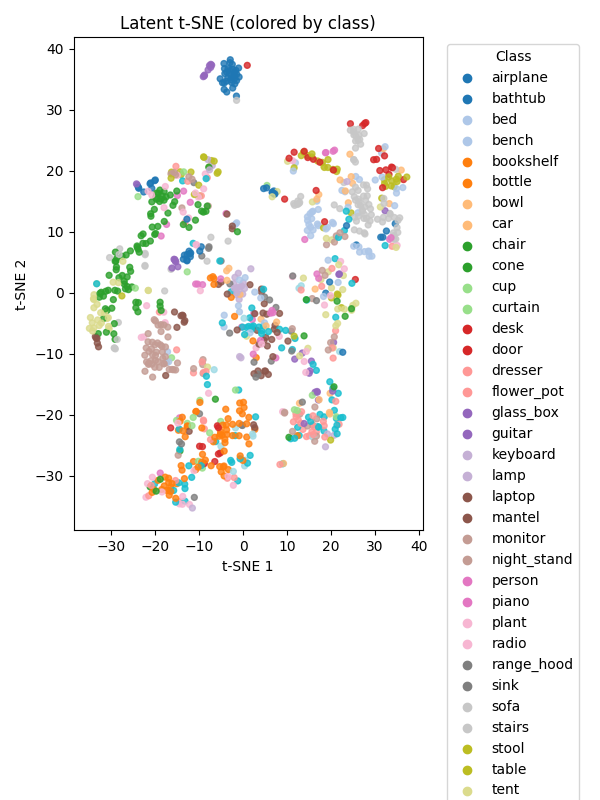

In [17]:
%matplotlib widget

import mplcursors
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

if lat_arr.shape[0] > 2:
    lbls = np.array(all_graph_labels)
    if shape_names and lbls.max() < len(shape_names):
        class_names_arr = np.array([shape_names[l] for l in lbls])
    else:
        class_names_arr = lbls.astype(str)
    # Compute t-SNE embedding
    tsne = TSNE(n_components=2, random_state=42)
    lat_2d_tsne = tsne.fit_transform(lat_arr)
    fig, ax = plt.subplots(figsize=(6,8))
    scatter = ax.scatter(lat_2d_tsne[:,0], lat_2d_tsne[:,1], c=lbls, cmap='tab20', s=18, alpha=0.8)
    for cname in np.unique(class_names_arr):
        idxs = class_names_arr == cname
        ax.scatter([], [], label=cname, color=scatter.cmap(scatter.norm(lbls[idxs][0])))
    ax.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title('Latent t-SNE (colored by class)')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    mplcursors.cursor(scatter, hover=True).connect(
        "add", lambda sel: sel.annotation.set_text(class_names_arr[sel.index])
    )
    plt.tight_layout()
    plt.show()
   # For interactive mplcursors in Jupyter, use the %matplotlib notebook magic
    # This enables interactive features like hover/click in matplotlib plots

    # In VSCode Jupyter, %matplotlib notebook may not work as expected.
    # For interactive mplcursors, use %matplotlib widget if available, or just %matplotlib inline for static plots.
    # If you want interactive tooltips, %matplotlib widget is recommended:
    # Uncomment below if you want to try widget mode (requires ipympl extension):
    # %matplotlib widget
